# Variogram estimation

This notebook is used to implement your own variogram estimation algorithm.


In [ ]:
!pip install scikit-gstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 3.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

This chapter loads the data and transforms it into a CRS using meter as unit

In [ ]:
from pathlib import Path

PATH = Path('/content/drive/MyDrive/Geostatistics/content/data')

In [ ]:
import pandas as pd

data = pd.read_csv(PATH / 'precipitation_sums_2023-10-01.csv')
data

,station_id,start_date,end_date,latitude,longitude,height,name,state,geometry,value,quality
0,44,1971-03-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,52.9336,8.2370,44.0,Großenkneten,Niedersachsen,POINT (8.237 52.9336),133.5,3.0
1,73,1952-07-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,48.6183,13.0620,374.0,Aldersbach-Kramersepp,Bayern,POINT (13.062 48.6183),42.7,3.0
2,78,1961-01-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,52.4853,7.9125,64.0,Alfhausen,Niedersachsen,POINT (7.9125 52.4853),151.2,3.0
3,91,1978-11-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,50.7446,9.3450,304.0,Alsfeld-Eifa,Hessen,POINT (9.345 50.7446),69.3,3.0
4,96,2019-05-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,52.9437,12.8518,50.0,Neuruppin-Alt Ruppin,Brandenburg,POINT (12.8518 52.9437),107.7,3.0
...,...,...,...,...,...,...,...,...,...,...,...
443,15555,2016-05-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,47.8761,10.5849,815.0,Kaufbeuren-Oberbeuren,Bayern,POINT (10.5849 47.8761),67.5,3.0
444,15813,2022-04-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,52.5126,7.4131,40.0,Lingen-Baccum,Niedersachsen,POINT (7.4131 52.5126),135.9,3.0
445,19171,2020-09-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,54.0039,9.8555,13.0,Hasenkrug-Hardebek,Schleswig-Holstein,POINT (9.8555 54.0039),213.0,3.0
446,19172,2020-09-01 00:00:00+00:00,2024-03-31 00:00:00+00:00,54.0246,9.3880,48.0,Wacken,Schleswig-Holstein,POINT (9.388 54.0246),199.1,3.0


In [ ]:
import pyproj

# create a transform and apply
src = pyproj.CRS.from_epsg(4326)
tgt = pyproj.CRS.from_epsg(25832)
transform = pyproj.Transformer.from_crs(src, tgt, always_xy=True)
tuples = transform.transform(data.longitude.values, data.latitude.values)

# create the coordinates and values list
coordinates = list(zip(*tuples))
values = data.value.values.tolist()

## Calculate the lag classes and groups

You could also use your solution from the last exercise (Pairs.ipynb).
Here, we simply use scikit-gstat to do that step for us.

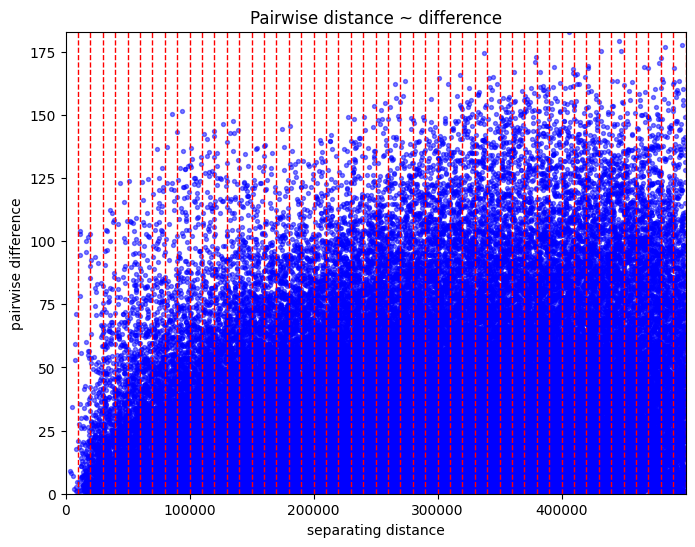

In [ ]:
import skgstat as skg

vario = skg.Variogram(coordinates, values, n_lags=50, maxlag=500_000, use_nugget=True)
fig = vario.distance_difference_plot()

## Task 6.1

Before we head to the empirical variogram, we need to implement the estimator functions. They will receive a list of observation residuals.


In [ ]:
import numpy as np

def matheron(obs_pairs) -> float:
  x = np.asarray(obs_pairs)
  if x.size == 0:
    return np.nan
  return np.sum(x**2) / (2 * x.size)

def cressie(obs_pairs) -> float:
  x = np.asarray(obs_pairs)
  if x.size == 0:
    return np.nan

  nominator = ((1 / x.size) * np.sum(np.power(x, 0.5)))**4
  denominator = 2 * (0.457 + (0.494 / x.size) + (0.045 / x.size**2))

  return nominator / denominator


## Task 6.2

With an estimator function in place, we can go ahead and extract the pair-wise observation residuals for each lag class, one at a time and and pass them into the function. This way we calculate the semi-variance and end up with the experimental values.

In [ ]:
# create a container for matheron and cressie semi-variance
experimental_matheron = []
experimental_cressie = []

# the number of lags is also accessible
for class_index in range(vario.n_lags):
  # get all differences at the current group index
  pairs = vario._diff[vario.lag_groups() == class_index]

  # calculate the semi-variance
  experimental_matheron.append(matheron(pairs))
  experimental_cressie.append(cressie(pairs))

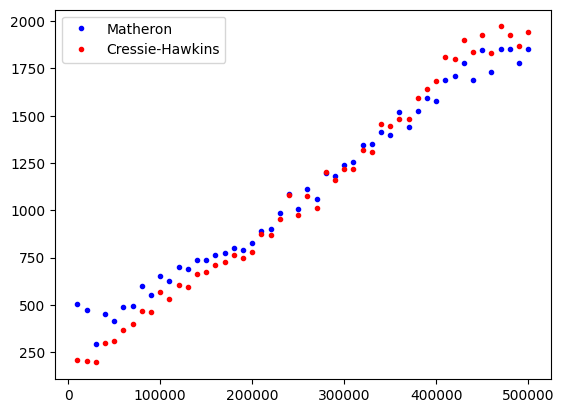

In [ ]:
# and plot it
import matplotlib.pyplot as plt

plt.plot(vario.bins, experimental_matheron, '.b', label='Matheron')
plt.plot(vario.bins, experimental_cressie, '.r', label='Cressie-Hawkins')
plt.legend()

## 7.1 Theoretical variogram models

Implement the spherical, exponential and gaussian model in a way, that you can parameterize them using the **effective** range, not the range parameter

In [ ]:
from math import e, pow

def spherical(h, a, C, C0=0.0) -> float:
  # derive the model parameter
  r = a / 1.0

  # if lag is larger than range, return
  if h >= r:
    return C0 + C

  # apply the model
  return C0 + C * ((3 / 2) * (h / r) - (1 / 2) * (h / r)**3)


def exponential(h, a, C, C0=0.0) -> float:
  r = a / 3
  return C0 + C * (1 - pow(e, -1 * (h / r)))

def gaussian(h, a, C, C0=0.0) -> float:
  r = a / 2
  return C0 + C * (1 - pow(e, -1 * (h**2 / r**2)))


## 7.3 Fitting a variogram model

For this task, we will estimate the variogram model parameters manually and parameterize the model function. use the cell below to change the parameters:

In [ ]:
import matplotlib.pyplot as plt

# change these parameters here:
NUGGET = 500
EFF_RANGE = 250_000
SILL = 1100

# specify the model
MODEL = exponential

# discreticise the function at 100 step from 0 up to the maximum lag distance
x = np.linspace(0, vario.maxlag, 100)

# parameterize the model - it should only take one parameter -> the dependent variable
par_model = lambda h: MODEL(h, EFF_RANGE, SILL, NUGGET)

# map the model on the input data
y = list(map(par_model, x))

# plot
plt.plot(vario.bins, experimental_matheron, '.b')
plt.plot(x, y, '-g')

# Task 8.1

We implement the function to build the kriging matrix for a subset of coordinates.

In [ ]:
from math import sqrt

def create_K(coordinates, vario_func):
  N = len(coordinates)

  # container
  K = []

  # create the NxN matrix for all coordinate combinations
  # for each row
  for i in range(N):
    row = []

    # for each column
    for j in range(N):
      # here, we do not skip the second triangle, but just calculate everything
      # for the sake of readablility

      # get the two points in question
      p1 = coordinates[i]
      p2 = coordinates[j]
      dist =

      semi_var =

      # add the semi-variance modeled for this point combination to the row
      row.append(semi_var)

    # the inner loop has finished, so add the last factor and append the row
    K.append(row + [1])

  # the outer loop has finished, so we add the last row
  K.append([1] * N + [0])

  # return K
  return K

In [ ]:
# test it with 15 locations
coords = coordinates[:15]

# create K
K = create_K(coords, par_model)

# just plot it
np.asarray(K)

# Task 8.2

In this task we add one more function to calcualte the result matrix to the unobserved location. Then we combine the function from task 8.1 with this function to finally make a prediction.

In [ ]:
def create_b(p0, coordinates, vario_model):
  N = len(coordinates)

  # create the result container
  b = []

  # go for each observation location
  for i in range(N):
    # IMPLEMENT HERE
    semi_var = 42

    # append the semi-variance modelled to the result vector
    b.append(semi_var)

  # before we return, we need to add the last factor to enforce unbiasedness
  return b + [1]

In [ ]:
# we use the midpoint of the coordinates as the unobserved location
x, y = np.mean(coords, axis=0)

# now test b
b = create_b((x, y), coords, par_model)

# just to plot it
np.asarray(b)

Implement the Oridniary Kriging algorithm down here

In [ ]:
from scipy.linalg import inv

# implement the function wiring it up:
def krige(p0, coordinates, values, vario_func):
  # create the kriging matrix
  K = create_K(coordinates, vario_func)

  # create the result vector
  b = create_b(p0, coordinates, vario_func)

  # now invert K and calcualte the weights
  # this one can also go wrong
  try:
    w = inv(K).dot(b)
  except Exception as e:
    print(f"Error at ({p0[0]} {p0[1]}): {str(e)}")
    return np.nan, np.nan

  # N - 1 elements are now the weights, w[-1] is the Lagrange multiplier

  # IMPLEMENT HERE
  pred = sum([42 for i in range(len(w) - 1)])
  var = sum([42 for i in range(len(w) - 1)]) + w[-1]

  return pred, var

In [ ]:
# we use the midpoint of the coordinates as the unobserved location
coords = coordinates[:15]
vals = values[:15]
x, y = np.mean(coords, axis=0)

# now use the function to make a prediction
pred, var = krige((x, y), coords, vals, par_model)

print(f'Prediction: {pred}')
print(f'Variance: {var}')

print(f'\nSample Mean: {np.mean(vals)}')
print(f'Sample Variance: {np.var(vals)}')

# Task 8.3

The only thing we need before we can run the full interpolation, is a function that pre-selects the observations that are used for kriging.

In [ ]:
def select_observations_by_range(p0, coordinates, values, eff_range, max_n = None):
  # calculate the distance from p0 to all coordinates
  dists = [sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2) for p1 in coordinates]

  # get the sorting index for dists
  indices = np.argsort(dists)

  # mask everything that is outside the effective range
  mask = [dists[i] > eff_range for i in indices]

  # now filter corrdinates and values by the indices if they are not masked out
  coords = [coordinates[i] for i in indices if not mask[i]]
  vals = [values[i] for i in indices if not mask[i]]

  return coords, vals


In [ ]:
# we test it:

# select the 5 closest observation locations to Karlsruhe

x, y = transform.transform(8.41980412013418, 48.98556235886618)

coords, vals = select_observations_by_range((x, y), coordinates, values, EFF_RANGE, max_n = 5)

print(coords, vals)

# Task 8.4

Finally, we wire everything up and run an interpolation for whole of Germany.


First of all we build a grid

In [ ]:
# define the resolution
# resolution = 1000
resolution = 5000

# build the grid
c = np.asarray(coordinates)
minx = c[:,0].min()
maxx = c[:,0].max()
miny = c[:,1].min()
maxy = c[:,1].max()

# span the grid
xgrid = np.arange(minx, maxx, resolution)
ygrid = np.arange(miny, maxy, resolution)

print(f"Build a {len(xgrid)}x{len(ygrid)} {resolution}m resolved grid totaling: {len(xgrid) * len(ygrid)} cells")

Build a 626x846 1000m resolved grid totaling: 529596 cells


Now we run the algorithm

In [ ]:
from tqdm import tqdm
import time

MAX_N = 15

t1 = time.time()
# we pre-create the grid and fill with NaN
prediction = np.ones((len(xgrid), len(ygrid))) * np.nan
variance = np.ones((len(xgrid), len(ygrid))) * np.nan

# this is quite slow but illustrates, what is happening
for i, x in tqdm(enumerate(xgrid), total=len(xgrid)):
  for j, y in enumerate(ygrid):
    # select the observations to use
    coords, vals = select_observations_by_range((x, y), coordinates, values, EFF_RANGE, max_n = MAX_N)

    # make the prediction
    pred, var = krige((x, y), coords, vals, par_model)

    # update the grid
    prediction[i][j] = pred
    variance[i][j] = var

t2 = time.time()
print(f"\nFinished after: {t2 - t1} seconds")

100%|██████████| 626/626 [10:03<00:00,  1.04it/s]


Finished after: 603.4397187232971 seconds


In [ ]:
print(np.var(values))
print(np.std(values))

filtered_prediction = np.where(np.asarray(variance) > np.var(values) +0.5, np.nan, np.asarray(prediction))

1399.7086702806123
37.41268060805871


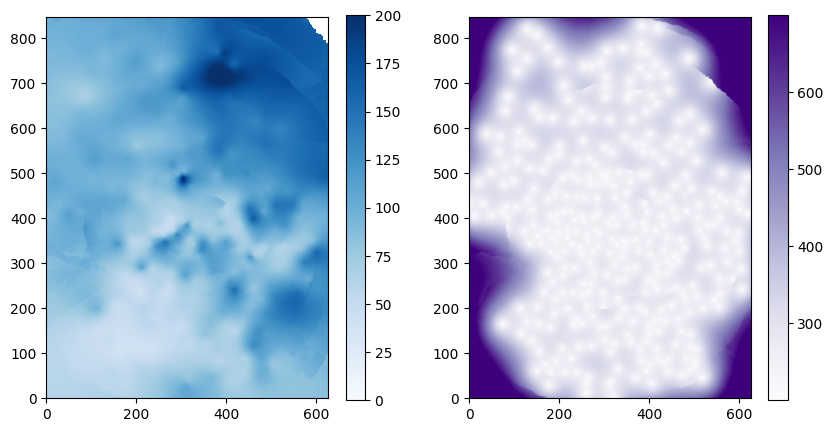

In [ ]:
# plot the result
import matplotlib.pyplot as plt

# we put in row of smallest latitude first, so we have to reorder, to make it the last row
# additionally we need to transpose, so that the x-axis uses the right coordiantes
pred = np.flipud(filtered_prediction).T
var = np.flipud(variance).T

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

m1 = axes[0].imshow(pred, origin='lower', cmap='Blues', vmin=0, vmax=200)
m2 = axes[1].imshow(var, origin='lower', cmap='Purples', vmax=np.var(values) * 0.5)
plt.colorbar(m1, ax=axes[0])
plt.colorbar(m2, ax=axes[1])
